# Deep Q-Learning DQN

 In this homework we will implement DQN for frozn lake environment

## Q-Learning Algorithm

Q-learning is an algorithm that repeatedly adjusts Q Value to minimize the Bellman error.
$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \underbrace{\left [ r(s,a) + \gamma \max_{a'} Q(s_{t+1},a') - Q(s_t,a_t) \right ]}_{\text{Bellman Error}}$$

The Q-value function at state s and action a, is the expected cumulative reward from taking action a in state s and then following the policy:
$$Q(s,a) = \mathbb{E} \left [ \sum_{t \geq 0} \gamma^t r_t \right ]$$

We learn these Q-values using the Q-learning algorithm.<br>

The discount factor $\gamma$ is the weight for future rewards.<br>

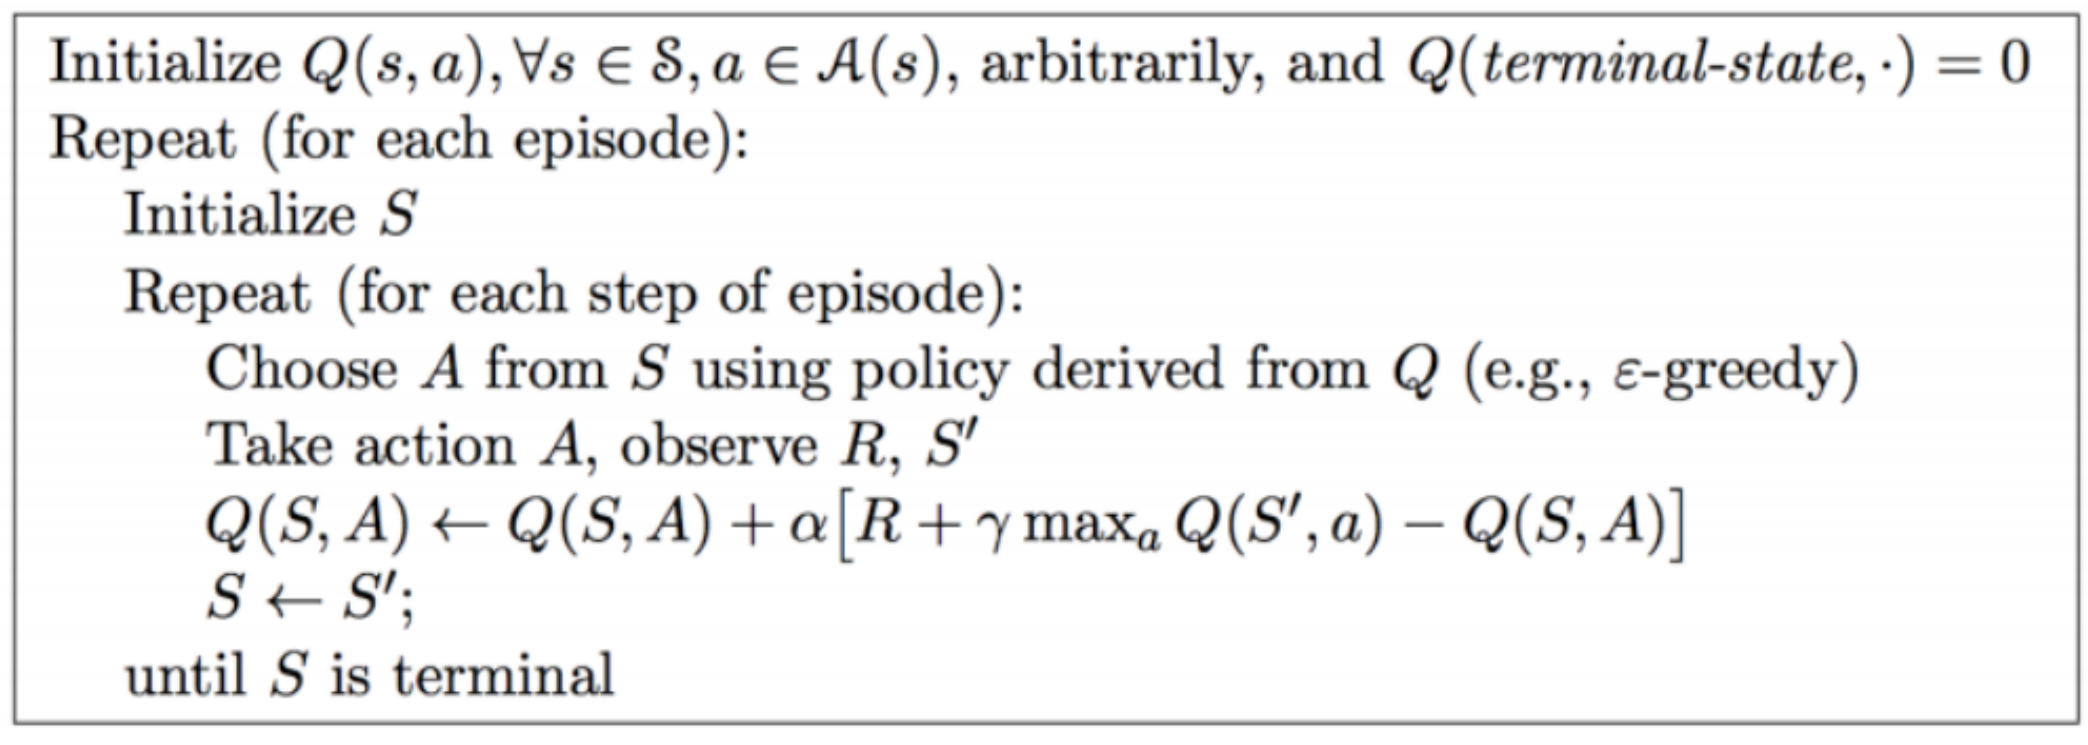

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create the environment
env = gym.make("FrozenLake-v1", is_slippery=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# Named tuple representing a single transition in our environment
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done')) # represents single transition in the environment

# Cyclic buffer of bounded size that holds and samples the transitions observed recently
class ReplayMemory(object): #
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
# A neural network approximator for Q-Value.
# It takes the state as input and predicts the Q-value for all actions at that state
class DQN(nn.Module): # network for approx. Q-values
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.embedding = nn.Embedding(n_observations, 16)
        self.layer1 = nn.Linear(16, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, 128)
        self.layer5 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = self.embedding(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        return self.layer5(x)

In [ ]:
# Here, we will specify the hyperparameters

total_episodes = 4000         # Total training episodes
max_steps = 100               # Max steps per episode (adjusted for FrozenLake)
learning_rate = 1e-3          # Learning rate
gamma = 0.8                   # Discounting rate
batch_size = 128              # Training Batch size
target_update = 5             # Target network update frequency
train_frquency = 1            # Train Q network every train_frquency episodes
train_epochs = 2              # Training epochs during each training cycle

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.0005           # Exponential decay rate for exploration prob

In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.n
action_size = env.action_space.n
print('state size:', state_size)
print('action size:', action_size)

observation space: Discrete(16)
action space: Discrete(4)
state size: 16
action size: 4


In [ ]:
# Intialize both Q-networks
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)

# update target network
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# set up the optimizer
optimizer = optim.RMSprop(policy_net.parameters(), lr=learning_rate)

# Initialize the replay buffer
memory = ReplayMemory(10000)

In [ ]:
# get action for current state according to the greedy policy
def get_action(state):
    ## First we randomize a number
    exp_exp_tradeoff = random.uniform(0, 1)
    ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
    if exp_exp_tradeoff > epsilon:
        with torch.no_grad():
            state = torch.tensor([state], device=device).long()  # Convert state to tensor
            q_values = policy_net(state)
            action = q_values.argmax().item()
    # Else doing a random choice --> exploration
    else:
        action = env.action_space.sample()
    return action

In [ ]:
#######################################################
#######################################################

rewards = []
success_rate = 0.0

for episode in range(1, total_episodes+1):
    # Initialize the environment and state
    state = env.reset()
    success = False  # To track if the agent reaches the goal
    for _ in range(max_steps):
        # Select and perform an action
        action = get_action(state)
        next_state, reward, done, _ = env.step(action)

        # Store the transition in memory
        memory.push(state, action, next_state, reward, done)

        # Move to the next state
        state = next_state

        if done:
            if reward == 1.0:  # The agent reached the goal
                success = True
            break

    # optimize the policy
    if episode % train_frquency == 0 and len(memory) >= batch_size:
        for _ in range(train_epochs):
            # get samples from experience replay memory
            transitions = memory.sample(batch_size)
            # unroll and reroll to get them in proper format
            batch = Transition(*zip(*transitions))

            state_batch = torch.tensor(batch.state, device=device).long()  # Convert state to Long data type
            action_batch = torch.tensor(batch.action, device=device).long()  # Convert action to Long data type
            next_state_batch = torch.tensor(batch.next_state, device=device).long()  # Convert next_state to Long data type
            reward_batch = torch.tensor(batch.reward, device=device).float()
            done_batch = torch.tensor(batch.done, device=device).float()

            # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
            # columns of actions taken
            state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1))

            # Compute V(s_{t+1}) for all next states and get the max q values.
            with torch.no_grad():
                next_state_values = target_net(next_state_batch).max(1)[0].detach()
            # Compute the target Q values
            target_q_values = (next_state_values * (1-done_batch) * gamma) + reward_batch

            # Compute Huber loss
            loss = F.smooth_l1_loss(state_action_values, target_q_values.unsqueeze(1))

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Update the target network
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

    # Track success rate
    if success:
        success_rate += 1

    rewards.append(success_rate / episode)  # Track the success rate, not total_rewards
    print(f"Episode {episode}: Success Rate = {success_rate / episode}, Epsilon = {epsilon}")

Episode 1: Success Rate = 0.0, Epsilon = 0.9995051237293776
Episode 2: Success Rate = 0.0, Epsilon = 0.9990104948350412
Episode 3: Success Rate = 0.0, Epsilon = 0.9985161131933338
Episode 4: Success Rate = 0.0, Epsilon = 0.9980219786806598
Episode 5: Success Rate = 0.0, Epsilon = 0.9975280911734855
Episode 6: Success Rate = 0.0, Epsilon = 0.9970344505483393
Episode 7: Success Rate = 0.0, Epsilon = 0.9965410566818107
Episode 8: Success Rate = 0.0, Epsilon = 0.9960479094505515
Episode 9: Success Rate = 0.0, Epsilon = 0.9955550087312749
Episode 10: Success Rate = 0.0, Epsilon = 0.9950623544007555
Episode 11: Success Rate = 0.0, Epsilon = 0.9945699463358298
Episode 12: Success Rate = 0.0, Epsilon = 0.9940777844133959
Episode 13: Success Rate = 0.0, Epsilon = 0.9935858685104132
Episode 14: Success Rate = 0.0, Epsilon = 0.9930941985039028
Episode 15: Success Rate = 0.0, Epsilon = 0.992602774270947
Episode 16: Success Rate = 0.0, Epsilon = 0.99211159568869
Episode 17: Success Rate = 0.0, Epsi

Text(0, 0.5, 'Reward')

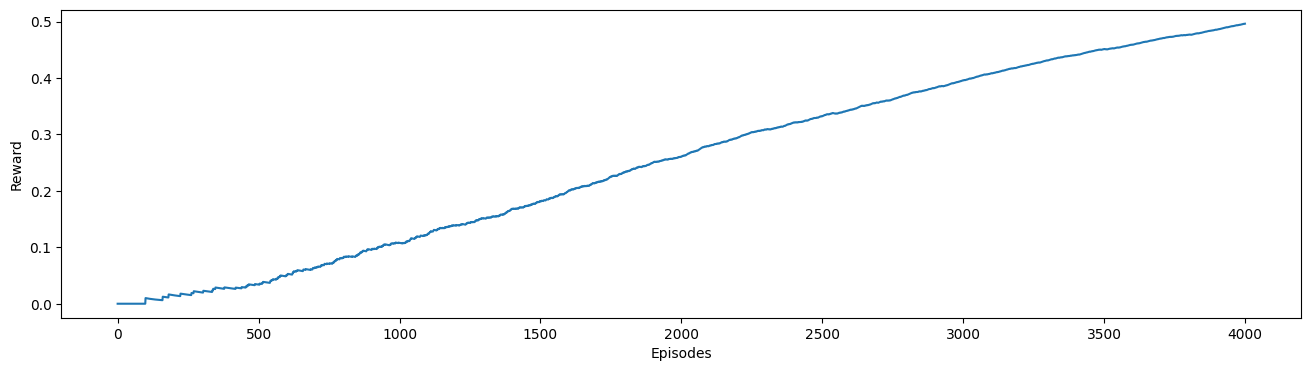

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(rewards)
plt.xlabel("Episodes")
plt.ylabel("Reward")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment FrozenLake-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.

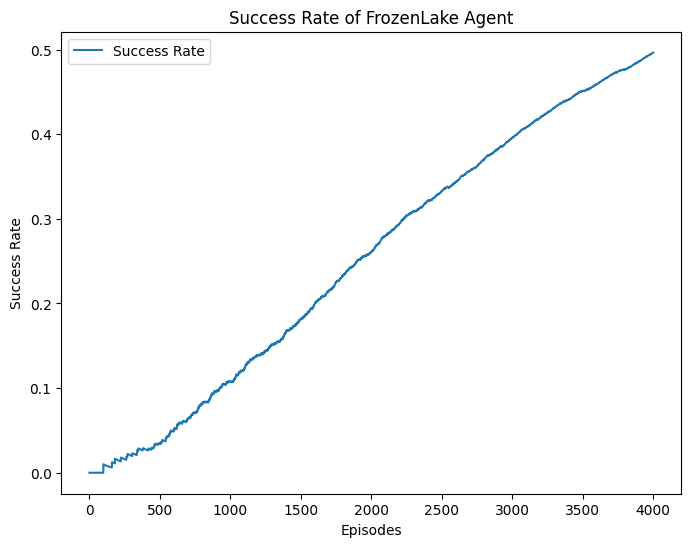

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action = get_action(state)
        next_state, _, done, _ = env.step(action)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()

# Visualize the agent's performance
for episode in range(5):  # Visualize 5 episodes
    show_video_of_model("FrozenLake-v1")

show_video("FrozenLake-v1")

# Show the average success rate in the form of a plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, total_episodes+1), rewards, label="Success Rate")
plt.xlabel("Episodes")
plt.ylabel("Success Rate")
plt.title("Success Rate of FrozenLake Agent")
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
show_video_of_model("FrozenLake-v1")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment FrozenLake-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [ ]:
show_video("FrozenLake-v1")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
